In [1]:
%matplotlib inline
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
from matplotlib import pyplot as plt
import pyshtools as pysht
import pyshtools.shtools as sht
import pyshtools.constant as shconstant
import numpy as np
import MapDrawer as MD
plt.rcParams['figure.figsize'] = [12.0,8.0]

In [2]:
# These are in the "geodesy" normalization convention: the SHTools default (norm=1)
max_degree = 2190
#max_degree = 2159
coeffs,errors,lmax = sht.SHReadError('EGM2008_to2190_ZeroTide.shm',max_degree)

If you wish to use the precise constants from GRS80, enable the following cell and use those values rather than the WGS84 version below.

In [3]:
# These are the values for WGS84 stored within SHTools itself.
omega_earth = shconstant.wgs84_omega
#print omega_earth
a_earth = shconstant.wgs84_a
#print a_earth
b_earth = shconstant.wgs84_b
#print b_earth
GM_earth = shconstant.wgs84_gm
# That differs in the 7th decimal place from the value given above for GRS80
#print GM_earth
f_earth = shconstant.wgs84_f
# That varies in the 9th significant digit from the value given above for GRS80.
#print f_earth
pot_ref_geoid_earth = shconstant.wgs84_u0
#print pot_ref_geoid_earth
# That varies in the 7th significant digit from the value given above for GRS80
r0pot_earth = shconstant.r0_pot_earth

In [4]:
geoid = sht.MakeGeoidGridDH(coeffs,
                            r0pot = r0pot_earth,
                            GM = GM_earth,
                            PotRef=pot_ref_geoid_earth,
                            omega=omega_earth,
                            a = a_earth,
                            f = f_earth,
                            order=1)

Sanity check.

Does the geoid "look reasonable"???

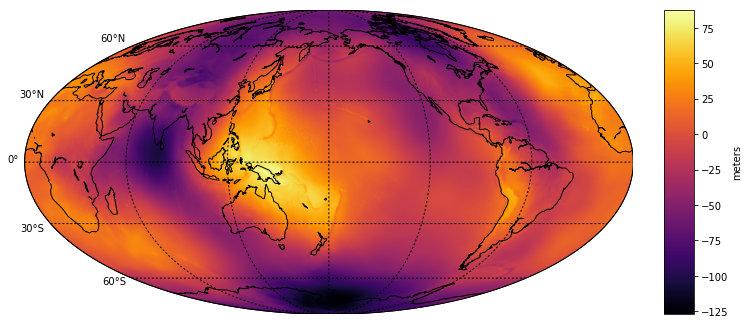

In [5]:
md = MD.MapDrawer('moll',geoid)
md.DrawMap(geoid,lon_0=180,units_label='meters')

I've experienced troubles with MakeGravGridDH, so let's do another sanity check by
checking that it's disturbing potential ($T$) matches that from Brun's formula. 

So, calculate the first order approximation to $T$ via Brun's formula:

4382 8764


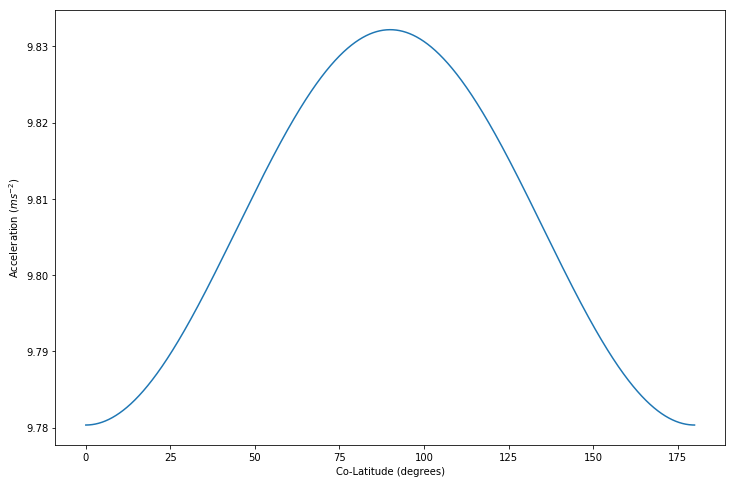

In [7]:
nlat,nlon = geoid.shape
print nlat, nlon
dlat = 180. / nlat
lats = np.linspace(0. + (dlat / 2.), 180. - (dlat / 2.), nlat)

normal_gravs = [sht.NormalGravity(lat,GM_earth,omega_earth,a_earth,b_earth) for lat in lats]
ng = np.array(normal_gravs,np.float64)
plt.plot(lats,ng)
plt.ylabel('Acceleration ($m s^{-2})$')
plt.xlabel('Co-Latitude (degrees)')


-1244.05382346 862.788377121


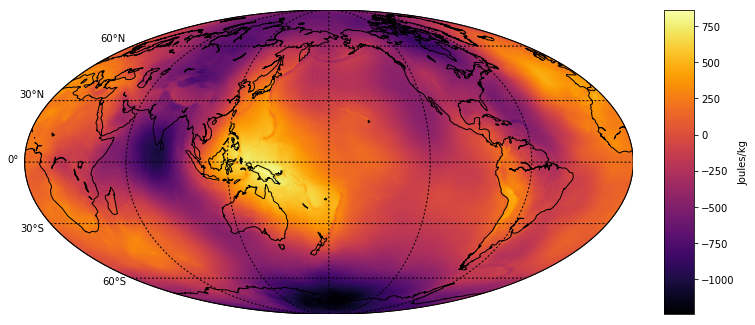

In [8]:
# Brun's formula
T = geoid * ng[:,np.newaxis]
md.DrawMap(T,lon_0=180,units_label='Joules/kg')
print T.min(),T.max()

Attempt to calculate everything with the normal gravity removed via MakeGravGrid.

In principle, the output _pot_ should be $T$, if I understand things correctly.

In [9]:
# THIS ONE IS FROM SHTOOLS DIRECTLY
rad, theta, phi, total, pot = sht.MakeGravGridDH (coeffs, 
                                                  gm=GM_earth, 
                                                  r0=r0pot_earth, 
                                                  a=a_earth, 
                                                  f=f_earth,
                                                  sampling=2,
                                                  normal_gravity=1,  # Trying to remove
                                                  omega=omega_earth, # normal gravity
                                                  lmax_calc=720)



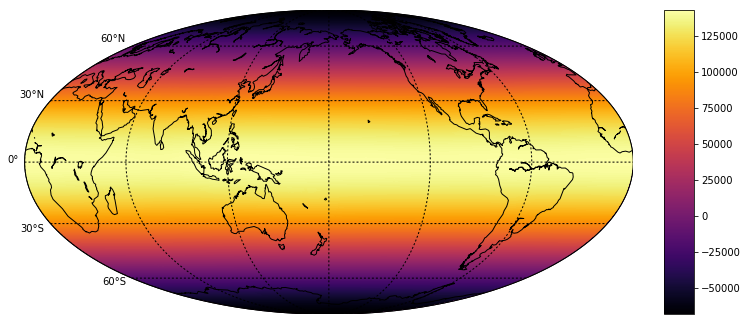

In [10]:
md_small = MD.MapDrawer('moll',pot)
md_small.DrawMap(pot)
# The order of magnitude from this result is WAAAAAY off. 
# And the normal gravity is still in the result.
# IS THIS A BUG IN SHTOOLS?
# Or, am I miscalling MakeGravGridDH??????
# I need to track this down with the author of the code before I go much further...
